In [16]:
# dependencies

import re
import datetime

import numpy as np
import pandas as pd
import pystan as stan
import matplotlib.pyplot as plt
import seaborn as sns

import xfx.mvglm.multinomial

In [17]:
# helper functions

def package_rfx_samples(rfx_samples, factor_names, response_names, algo_name, chain_ix, epoch_ix):

    dfs = []
    for i, (samples_, factor_name) in enumerate(zip(rfx_samples, factor_names)):
        for j in range(samples_.shape[1]):
            df_ = pd.DataFrame(samples_[:, j].T, index=response_names)
            df_.index = df_.index.rename('response')
            df_.columns = df_.columns.rename('iter')
            df_['algo'] = algo_name
            df_['chain'] = chain_ix
            df_['epoch'] = epoch_ix
            df_['factor'] = factor_name
            df_['level'] = j
            dfs.append(df_)
    df = pd.concat(dfs).reset_index().set_index(['algo', 'chain', 'epoch', 'factor', 'level', 'response'])
    return df

def est_post_moms(samples):

    df = pd.DataFrame(index=samples.index)
    df['mean'] = samples.mean(1)
    df['log_sd'] = np.log(samples.std(1))
    df.columns = df.columns.rename('summary')
    return df.stack().rename('value')

def summ_err(summ, summ_gt):

    err = np.abs(summ - summ_gt)
    err_med = err.groupby(level=('algo', 'chain', 'epoch', 'summary')).median()
    err_max = err.groupby(level=('algo', 'chain', 'epoch', 'summary')).max()
    df = pd.DataFrame({'med': err_med, 'max': err_max})
    df.columns = df.columns.rename('quantile')
    return df
    
def sample_cgibbs_table(cgibbs_inputs, stan_model, advi_inputs, n_chains, n_epochs, factor_names, response_names, tepoch, titer, failed_seeds):

    return pd.concat([sample_cgibbs_sequence(cgibbs_inputs, stan_model, advi_inputs, chain_ix, n_epochs, factor_names, response_names, tepoch, titer) for chain_ix in range(n_chains + len(failed_seeds)) if chain_ix not in failed_seeds])

def sample_cgibbs_sequence(cgibbs_inputs, stan_model, advi_inputs, chain_ix, n_epochs, factor_names, response_names, tepoch, titer):

    rng = np.random.default_rng(chain_ix)
    advi_samples = stan_model.vb(data=advi_inputs, iter=1, init=0, seed=chain_ix)#rng.integers(0, 2147483647))
    advi_arrays = format_advi_output(advi_samples['sampler_param_names'], advi_samples['sampler_params'])
    init = (np.mean(advi_arrays['intercept'][:, :-1], 0),
            [np.mean(advi_arrays['coefs'][:, :-1], 0).T[lo:(hi+1)] for lo, hi in zip(advi_inputs['lo'] - 1, advi_inputs['hi'] - 1)],
            [np.linalg.inv(a) for a in np.mean(advi_arrays['cov_factor'], 0)])
    n_samples = int(tepoch * n_epochs / titer) + 1
    sampler = xfx.mvglm.multinomial.sample_posterior(*cgibbs_inputs, init=init, ome=rng)
    samples = [next(sampler) for _ in  range(n_samples)]
    rfx_samples = package_cgibbs_samples(samples, factor_names, response_names, chain_ix, 0)
    return split_epochs(rfx_samples, n_epochs, tepoch, titer)

def package_cgibbs_samples(samples, factor_names, response_names, chain_ix, epoch_ix):

    rfx_samples, _ = zip(*samples)
    rfx_samples = [np.array(samples_) for samples_ in zip(*rfx_samples)]
    return package_rfx_samples(rfx_samples, ['_const'] + factor_names, response_names, 'cGibbs', chain_ix, epoch_ix)

def split_epochs(samples, n_epochs, tepoch, titer):

    n_samples = np.int64(np.arange(1, n_epochs + 1) * (tepoch / titer))
    summ_by_epoch = [est_post_moms(samples.iloc[:, (n // 2):(n)]).reset_index() for n in n_samples]
    for i, summ_ in enumerate(summ_by_epoch):
        summ_['epoch'] = i
    summ_by_epoch = pd.concat(summ_by_epoch)
    return summ_by_epoch.set_index(summ_by_epoch.columns.drop('value').tolist()).value

def package_advi_samples(samples, data, factor_names, response_names, chain_ix, epoch_ix):

    alp0_samples = samples['intercept'][:, :-1]
    alp_samples = [[alp_[:, lo:(hi+1)].T for lo, hi in zip(data['lo'] - 1, data['hi'] - 1)] for alp_ in samples['coefs'][:, :-1]]
    rfx_samples = [np.array(samples_) for samples_ in zip(*[[alp0_[np.newaxis]] + alp_ for alp0_, alp_ in zip(alp0_samples, alp_samples)])]
    return package_rfx_samples(rfx_samples, ['_const'] + factor_names, response_names, 'Stan/ADVI', chain_ix, epoch_ix)

def sample_advi_table(model, data, n_iter, n_chains, n_epochs, factor_names, response_names):

    i = 0
    summ_coefs = []
    failed_seeds = []
    while len(summ_coefs) < n_chains:
        try:
            summ_coefs.append(sample_advi_sequence(model, data, n_iter, i, n_epochs, factor_names, response_names))
        except RuntimeError:
            failed_seeds.append(i)
        i += 1
    return pd.concat(summ_coefs), failed_seeds

def sample_advi_sequence(model, data, n_iter, chain_ix, n_epochs, factor_names, response_names):

    summ_coefs = [sample_advi_cell(model, data, n_iter, chain_ix, i, factor_names, response_names) for i in range(n_epochs)]
    return pd.concat(summ_coefs)

def sample_advi_cell(model, data, n_iter, chain_ix, epoch_ix, factor_names, response_names):

    rng = np.random.default_rng(chain_ix)
    samples = model.vb(data=data, iter=n_iter*(epoch_ix+1), init=0, seed=chain_ix, tol_rel_obj=1e-9)
    arrays = format_advi_output(samples['sampler_param_names'], samples['sampler_params'])
    rfx_samples = package_advi_samples(arrays, data, factor_names, response_names, chain_ix, epoch_ix)
    rfx_summ = est_post_moms(rfx_samples)
    return rfx_summ

def format_advi_output(block_names, block_samples):

    uq_names = list(set([s.split('[')[0] for s in block_names]))
    indices = {un: np.int32([re.findall('\[(.+)\]', n)[0].split(',') if '[' in n else np.array([]) for n in block_names if un == n.split('[')[0]]) - 1 for un in uq_names}
    samples = {un: [s for n, s in zip(block_names, block_samples) if un == n.split('[')[0]] for un in uq_names}
    arrays = {un: np.empty(np.append(indices[un].max(0) + 1, 1000)) for un in uq_names}
    for un in uq_names:
        for ix, s in zip(indices[un], samples[un]):
            arrays[un][tuple(ix)] = s
        arrays[un] = np.transpose(arrays[un], [-1, *range(len(arrays[un].shape) - 1)])
    return arrays

In [18]:
# config

factor_names = ['province_id', 'activity', 'age', 'education', 'municipality_size', 'voting_recall', 'gender']
response_names = ['conservatives', 'social_democrats']
exclude = ['abstention', 'invalid']

n_chains = 10
n_epochs = 10
n_iter = 1024

In [19]:
# construct inputs

summ_gt = pd.read_csv('paper/output/exact_benchmark_gt.csv').set_index(['level', 'factor', 'response', 'summary']).value
cis = pd.read_csv('paper/data/cis.csv')
cis = cis.loc[(cis.study_id == '2019-11-10') & (~cis.voting_intention.isin(exclude)) & (~cis.voting_intention.isna())]
cis['response'] = np.where(cis.voting_intention.isin(response_names), cis.voting_intention, '_others')
cis['voting_recall'] = np.where(cis.voting_recall.isin(response_names), cis.voting_recall, '_others')
cis = cis[factor_names + ['response']].dropna()
codes = cis.apply(lambda x: x.astype('category').cat.codes)
response = pd.get_dummies(codes.response)
indices = codes.drop('response', 1)
n_levels = np.max(indices, 0).astype(np.int64) + 1

In [20]:
# construct advi inputs

counts = codes.groupby(codes.columns.tolist()).size().unstack('response').fillna(0)
coef_idx = counts.index.to_frame() + np.hstack([0, np.cumsum(n_levels[:-1])]) + 1
advi_inputs = {
    'n_strata': counts.shape[0],
    'n_parties': counts.shape[1],
    'n_factors': len(n_levels),
    'n_coefs': n_levels.sum(),
    'prior_df': counts.shape[1] - 1,
    'lo': np.hstack([0, np.cumsum(n_levels[:-1])]) + 1,
    'hi': np.cumsum(n_levels).values,
    'coef_idx': coef_idx.values,
    'counts': counts.applymap(int).values}

In [21]:
# measure advi iteration time

stan_model = stan.StanModel('paper/stan/xfx_mvlogit2.stan')
t0 = datetime.datetime.now()
stan_model.vb(data=advi_inputs, seed=0, iter=n_iter * n_epochs, tol_rel_obj=1e-9)
t1 = datetime.datetime.now()
tepoch = (t1 - t0).total_seconds() / n_epochs

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_cf96aaaa55bb5e41476a50e31d238c87 NOW.


In [22]:
# wall time per advi iteration block

print(tepoch)

6.1964782


In [23]:
# sample advi summaries

advi_summ, failed_seeds = sample_advi_table(stan_model, advi_inputs, n_iter, n_chains, n_epochs, factor_names, response_names)

In [24]:
# construct cgibbs inputs

prior_n_tau = np.repeat(len(response_names), len(n_levels))
cgibbs_inputs = (response.values, n_levels.values, indices.values, None, prior_n_tau)

In [25]:
# measure cgibbs iteration time

sampler = xfx.mvglm.multinomial.sample_posterior(*cgibbs_inputs, ome=np.random.default_rng(0))
next(sampler)
t0 = datetime.datetime.now()
all(next(sampler) for _ in  range(100))
t1 = datetime.datetime.now()
cgibbs_titer = (t1 - t0).total_seconds() / 100

In [26]:
# sample cgibbs summaries

cgibbs_summ = sample_cgibbs_table(cgibbs_inputs, stan_model, advi_inputs, n_chains, n_epochs, factor_names, response_names, tepoch, cgibbs_titer, failed_seeds)

In [27]:
# compute error stats

advi_err = summ_err(advi_summ, summ_gt)
cgibbs_err = summ_err(cgibbs_summ, summ_gt)
err = pd.concat([cgibbs_err, advi_err])

In [28]:
# dump

err.to_csv('paper/output/approx_benchmark_err.csv')

In [29]:
# configure for export

import matplotlib
sns.set()
matplotlib.rcParams.update({
    'font.family': ['serif'],
    'font.serif': ['Latin Modern Roman'],
    'axes.labelsize': 10,
    'axes.titlesize': 10,
    'font.size': 10
})

tepoch = 11.81
err = pd.read_csv('paper/output/approx_benchmark_err.csv')

/home/tim/.local/share/virtualenvs/xfx_remote-OVPgIAIG/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, hue. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


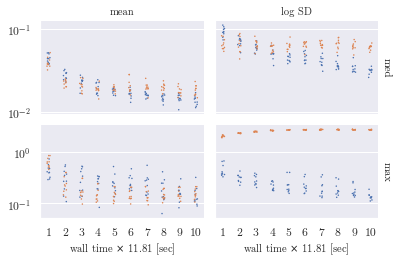

In [31]:
err_long = err.melt(id_vars=['algo', 'chain', 'epoch', 'summary'], var_name='quantile')
err_long['epoch'] += 1

g = sns.catplot('epoch', 'value', 'algo', row='quantile', col='summary', kind='strip', col_order=('mean', 'log_sd'), data=err_long, height=1.75, aspect=8/5, legend=False, margin_titles=True, s=1.5, sharey='row')
#g.fig.subplots_adjust(wspace=0.06, hspace=0.12)
g.set(ylabel=None, yscale='log')
g.set_titles(col_template='{col_name}', row_template='{row_name}')
g.axes[0,1].set_title('log SD')
g.axes[1,0].set(xlabel='wall time $\\times$ {0} [sec]'.format(np.round(tepoch, 2)))
g.axes[1,1].set(xlabel='wall time $\\times$ {0} [sec]'.format(np.round(tepoch, 2)))

plt.savefig('paper/plots/crossed_approx_benchmark_err.pdf', bbox_inches='tight', backend='pgf')